In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import h5py
import re
from scipy import stats
from scipy.stats import norm

In [2]:
np.__version__

'1.21.6'

In [3]:
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
filename = 'cluster_meta_n_14_clusters.h5'

In [6]:
file_path = os.path.join(directory, filename)
cluster_df = pd.read_hdf(file_path, key='df')

In [7]:
### functions
def get_table_long(cluster_df_all, location='area_layer', cluster_range = range(0, 12)):
    cluster_df_all['location'] = cluster_df_all[location].copy()
    table_cre = pd.DataFrame()
    
    for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
        areas = locations[location]
    
        # compute the table of proportions
        table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
        # make sure that there are 12 clusters for all
        table = table.reindex(cluster_range).reset_index()
   
        # add cre line
        table['cre_line'] = cre
        if i == 0:
            table_cre=table.copy()
        else:
            # concatinate tables with all cre
            table_cre = pd.concat([table_cre, table], ignore_index=True)

    # start with 1
    table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

    # convert to long format
    table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')

    return table_long

#### load cell table to find area and depth

In [8]:
import visual_behavior.data_access.loading as loading
cell_table = loading.get_cell_table()

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


In [9]:
cell_specimen_ids = cluster_df.cell_specimen_id.values

In [10]:
cell_table2 = cell_table[cell_table.cell_specimen_id.isin(cell_specimen_ids)]

In [11]:
cell_table2.keys()

Index(['cell_specimen_id', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'date', 'first_novel',
       'n_relative_to_first_novel', 'last_familiar', 'last_familiar_active',
       'second_novel', 'second_novel_active', 'experience_exposure'],
      dtype='object')

In [12]:
cell_table3 = cell_table2[['cell_specimen_id','cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'targeted_structure']]
cell_table4 = cell_table3.drop_duplicates('cell_specimen_id')

In [13]:
cluster_df_all = pd.merge(cluster_df, cell_table4, on='cell_specimen_id', how='inner')

In [14]:
cluster_df_all['location'] = cluster_df_all['area_layer'].copy()

#### use GLM clustering code to generate the area/depth analysis

In [15]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [16]:
cluster_df_all.location.unique()

array(['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower'],
      dtype=object)

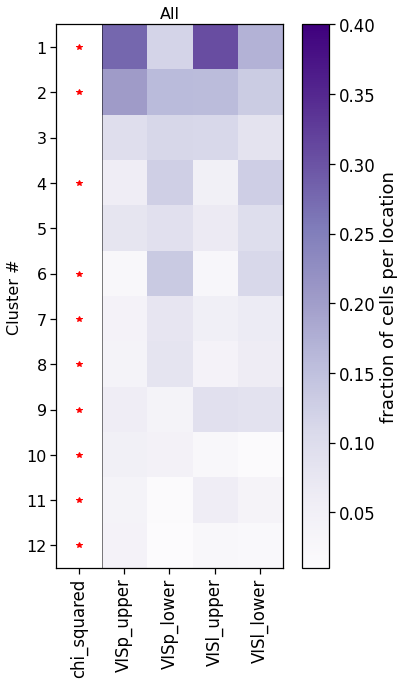

In [357]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']
cre = 'none'
fig, ax = plt.subplots(1,1, figsize = (7,10))
glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax, cre=cre,test='chi_squared_')

#### Use cre lines

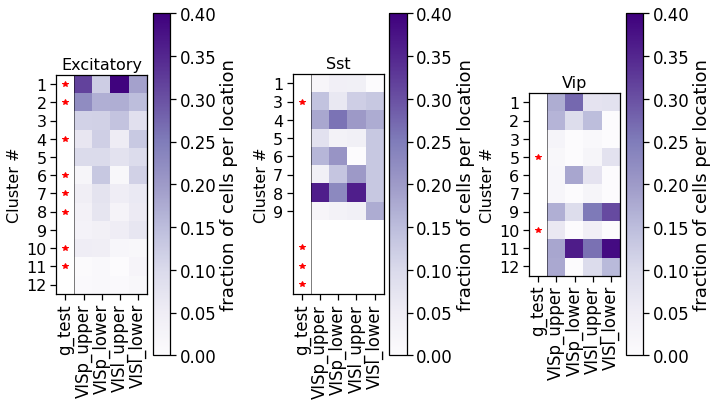

In [358]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']

fig, ax = plt.subplots(1,3, figsize = (10,7))
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax[i], cre=cre,test='g_test_')

plt.tight_layout()

Primary visual cortex:
- Overrepresentation of cluster 10 that is modulated by task during novelty. This is super interesting cause you would expect higher visual areas to integrate task related behaviors. This may be related to stronger modulation by movement or licking in the novel session. 

- When using g test, we do not see significant difference in areas for beahvioral cluster 9, which often pops up more LM based.

- non responsive cells are likely to be in superficial layers.

- Novelty cells are prominent in superficial V1.

- Deep layers are more consistently responding to all images, including familiar only. 

- Suppression by novelty excitatory cells are more common in deep layers, while SST are in superficial layers.

#### Bar plot of area and depth representation

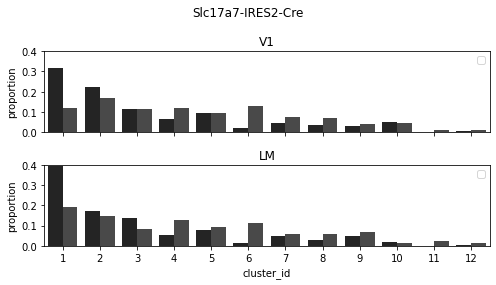

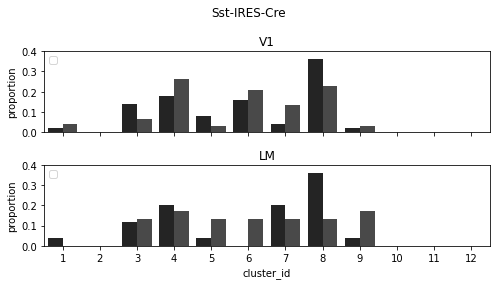

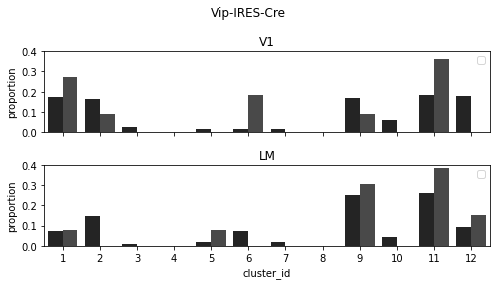

In [19]:

grey_palette = sns.color_palette("gray")
legend=True
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    fig, ax = plt.subplots(2,1, figsize = (7,4), sharex=True)
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    table['cluster_id'] = table['cluster_id'].copy()+1
    table_VISp = table[['cluster_id', 'VISp_upper', 'VISp_lower']]
    table_VISl = table[['cluster_id', 'VISl_upper', 'VISl_lower']]
    df_visp = pd.melt(table_VISp, id_vars=['cluster_id'], var_name='location', value_name='proportion')
    df_visl = pd.melt(table_VISl, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=df_visp, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[0])
    sns.barplot(data=df_visl, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[1])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[0].set_ylim([0, 0.4])
    ax[0].set_title('V1')
    ax[0].legend('')
    ax[0].set_xlabel('')
    ax[1].set_ylim([0, 0.4])
    ax[1].set_title('LM')
    ax[1].legend('')
    plt.suptitle(cre)
    plt.tight_layout()


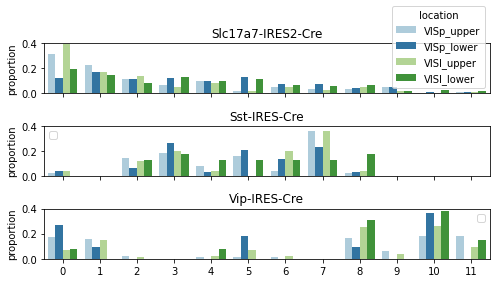

In [20]:

### plot on one bar plot

grey_palette = sns.color_palette("gray")
legend=True
fig, ax = plt.subplots(3,1, figsize = (7,4), sharex=True)

for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    
    table_long = pd.melt(table, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=table_long, x='cluster_id', y='proportion', hue='location', palette='Paired', ax=ax[i])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[i].set_ylim([0, 0.4])
    ax[i].set_title(cre)
    if i > 0:
        ax[i].legend('')
    ax[i].set_xlabel('')
   
    plt.tight_layout()


In [21]:
locations = {'targeted_structure': ['VISp', 'VISl'],
            'layer': ['upper', 'lower'],
            'area_layer':['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']}


In [22]:
# table_cre = table_cre[['cluster_id', 'cre_line', *locations[location]]]

### By different location per cluster

#### area

In [23]:
#get cluster df for specific location
location = 'targeted_structure'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [24]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1


In [25]:
table2_cre.sample()

location,cluster_id,VISp,VISl,VISp_chance_count,VISl_chance_count,g_test_pvalue,significant,imq,bh_significant,cre_line
15,4,34.0,9.0,32.360825,10.639175,0.555088,False,0.0375,False,Sst-IRES-Cre


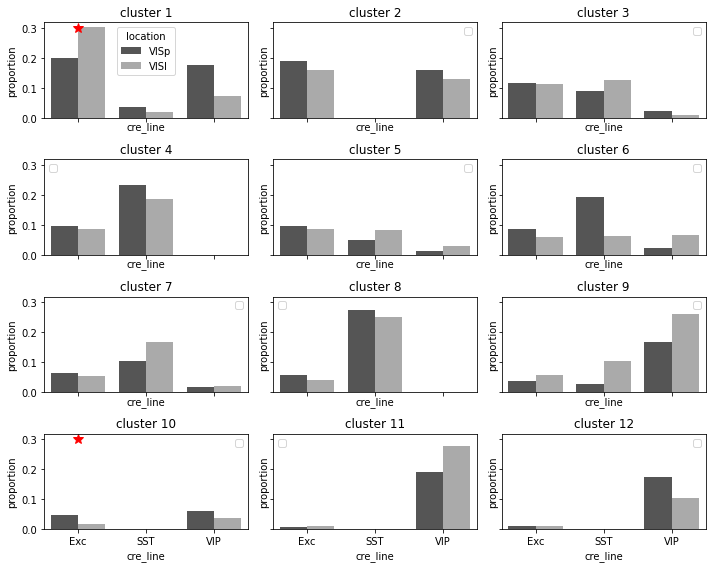

In [26]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
    # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### layer

In [27]:
#get cluster df for specific location
location = 'layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [28]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1



In [29]:
table2_cluster = table2_cre[table2_cre['cluster_id']==2][['cre_line', 'bh_significant']].reset_index(drop=True)
table2_cluster 

location,cre_line,bh_significant
0,Slc17a7-IRES2-Cre,True
1,Sst-IRES-Cre,NaN
2,Vip-IRES-Cre,False


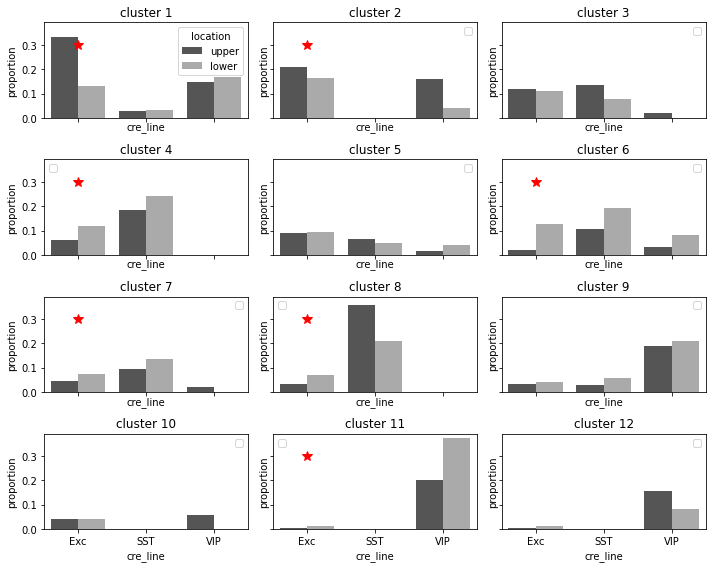

In [30]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### area and depth

In [31]:
#get cluster df for specific location
location = 'area_layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')


In [32]:
test = 'g_test_'
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reindex(cluster_range).reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1

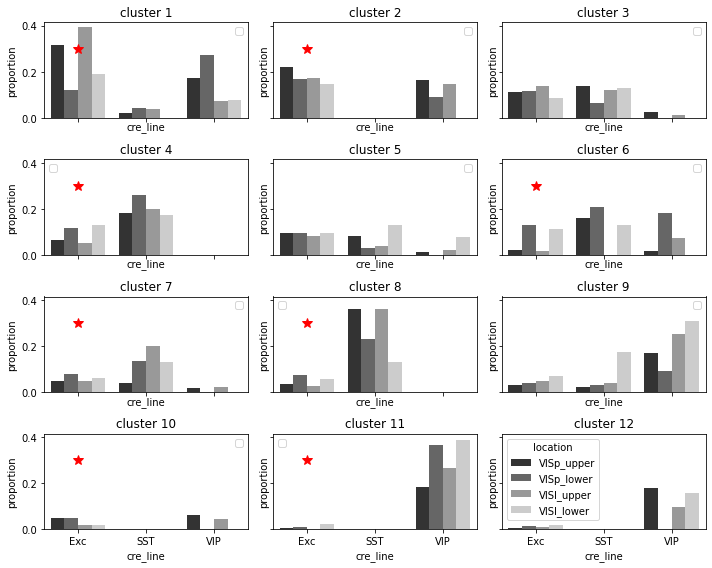

In [33]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant'] is True:
            ax.plot(index, 0.3,'r*', markersize = 10)
    if j != 11:
        ax.legend('')
plt.tight_layout()  



In [34]:
table2_cluster

location,cre_line,bh_significant
0,Slc17a7-IRES2-Cre,False
1,Sst-IRES-Cre,NaN
2,Vip-IRES-Cre,False


In [35]:
table_long[['area', 'layer']] = table_long['location'].str.split('_', expand=True)


In [36]:
table_layer = table_long.copy()

In [37]:
# Create new columns 'upper' and 'lower' based on 'layer' column
table_layer['upper'] = table_long['proportion'][table_long['layer'] == 'upper']
table_layer['lower'] = table_long['proportion'][table_long['layer'] == 'lower']

# Drop the 'layer' column
table_layer = table_layer.drop(columns=['layer'])

In [38]:
table2_layer = table_layer.groupby(['cluster_id', 'cre_line','area']).mean().reset_index()

In [39]:
table2_layer 

,cluster_id,cre_line,area,proportion,upper,lower
0,1,Slc17a7-IRES2-Cre,VISl,0.292305,0.394495,0.190114
1,1,Slc17a7-IRES2-Cre,VISp,0.218255,0.315884,0.120625
2,1,Sst-IRES-Cre,VISl,0.020000,0.040000,0.000000
3,1,Sst-IRES-Cre,VISp,0.030833,0.020000,0.041667
4,1,Vip-IRES-Cre,VISl,0.075304,0.073684,0.076923
...,...,...,...,...,...,...
67,12,Slc17a7-IRES2-Cre,VISp,0.008020,0.005415,0.010625
68,12,Sst-IRES-Cre,VISl,NaN,NaN,NaN
69,12,Sst-IRES-Cre,VISp,NaN,NaN,NaN
70,12,Vip-IRES-Cre,VISl,0.124291,0.094737,0.153846


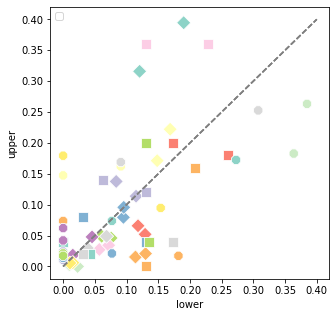

In [40]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(table2_layer.cre_line.unique()):
    sns.scatterplot(data=table2_layer[table2_layer.cre_line==cre] , x = 'lower', y = 'upper', 
                    hue = 'cluster_id', palette = 'Set3', s=100, marker=markers[c], ax=ax)
    ax.legend('')
    plt.plot([0, 0.4], [0,0.4], '--', color='gray')

### Modulation index by layer (table2_layer)

In [41]:
table2_layer['modulation_index'] = (table2_layer['upper'] - table2_layer['lower']) / (table2_layer['lower'] + table2_layer['upper'])


Text(0.5, 1.0, 'compbined across areas')

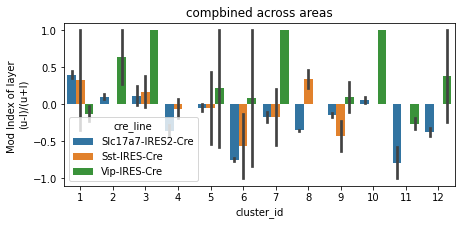

In [42]:
fig, ax= plt.subplots(1,1,figsize = (7,3))
ax=sns.barplot(data=table2_layer, x='cluster_id', y='modulation_index', hue='cre_line', ax=ax)
ax.set_ylabel('Mod Index of layer \n(u-l)/(u+l)')
ax.set_title('compbined across areas')

### Modulation index by area

In [43]:
table_long= get_table_long(cluster_df_all)
table_long.head()

,cluster_id,cre_line,location,proportion
0,1,Slc17a7-IRES2-Cre,VISp_upper,0.315884
1,2,Slc17a7-IRES2-Cre,VISp_upper,0.222022
2,3,Slc17a7-IRES2-Cre,VISp_upper,0.113718
3,4,Slc17a7-IRES2-Cre,VISp_upper,0.065884
4,5,Slc17a7-IRES2-Cre,VISp_upper,0.095668


In [44]:
table_long[['targeted_structure', 'layer']] = table_long['location'].str.split('_', expand=True)
table_area = table_long.copy()
table_area['VISp'] = table_long['proportion'][table_long['targeted_structure'] == 'VISp']
table_area['VISl'] = table_long['proportion'][table_long['targeted_structure'] == 'VISl']

# Drop the 'layer' column
table_area = table_area.drop(columns=['targeted_structure'])

In [45]:
table_area 

,cluster_id,cre_line,location,proportion,layer,VISp,VISl
0,1,Slc17a7-IRES2-Cre,VISp_upper,0.315884,upper,0.315884,NaN
1,2,Slc17a7-IRES2-Cre,VISp_upper,0.222022,upper,0.222022,NaN
2,3,Slc17a7-IRES2-Cre,VISp_upper,0.113718,upper,0.113718,NaN
3,4,Slc17a7-IRES2-Cre,VISp_upper,0.065884,upper,0.065884,NaN
4,5,Slc17a7-IRES2-Cre,VISp_upper,0.095668,upper,0.095668,NaN
...,...,...,...,...,...,...,...
139,8,Vip-IRES-Cre,VISl_lower,NaN,lower,NaN,NaN
140,9,Vip-IRES-Cre,VISl_lower,0.307692,lower,NaN,0.307692
141,10,Vip-IRES-Cre,VISl_lower,0.000000,lower,NaN,0.000000
142,11,Vip-IRES-Cre,VISl_lower,0.384615,lower,NaN,0.384615


In [46]:
table2_area = table_area.groupby(['cluster_id', 'cre_line','layer']).mean().reset_index()

table2_area['modulation_index'] = (table2_area['VISp'] - table2_area['VISl']) / (table2_area['VISp'] + table2_area['VISl'])


Text(0.5, 1.0, 'compbined across layers')

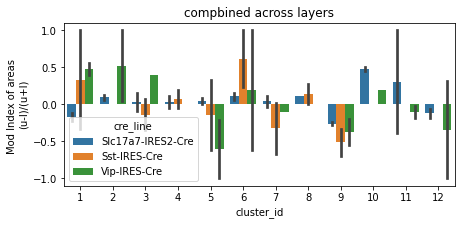

In [47]:
fig, ax= plt.subplots(1,1,figsize = (7,3))
ax=sns.barplot(data=table2_area, x='cluster_id', y='modulation_index', hue='cre_line', ax=ax)
ax.set_ylabel('Mod Index of areas \n(u-l)/(u+l)')
ax.set_title('compbined across layers')

In [48]:
combiend_table = table2_layer.copy()

In [49]:
combiend_table = combiend_table.join(table2_area[['modulation_index']], lsuffix= '_layer', rsuffix='_area')

In [50]:
combiend_table.head()

,cluster_id,cre_line,area,proportion,upper,lower,modulation_index_layer,modulation_index_area
0,1,Slc17a7-IRES2-Cre,VISl,0.292305,0.394495,0.190114,0.349603,-0.223625
1,1,Slc17a7-IRES2-Cre,VISp,0.218255,0.315884,0.120625,0.447320,-0.110660
2,1,Sst-IRES-Cre,VISl,0.020000,0.040000,0.000000,1.000000,1.000000
3,1,Sst-IRES-Cre,VISp,0.030833,0.020000,0.041667,-0.351351,-0.333333
4,1,Vip-IRES-Cre,VISl,0.075304,0.073684,0.076923,-0.021505,0.560000


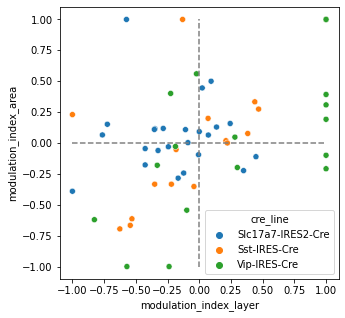

In [51]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.scatterplot(data=combiend_table, x='modulation_index_layer', y = 'modulation_index_area', hue = 'cre_line')
plt.plot([0, 0], [-1,1], '--', color='gray')
plt.plot([-1, 1], [0,0], '--', color='gray')

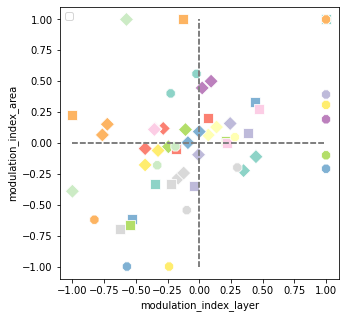

In [52]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(combiend_table.cre_line.unique()):
    sns.scatterplot(data=combiend_table[combiend_table.cre_line==cre], x='modulation_index_layer', y = 'modulation_index_area', hue = 'cluster_id',
         palette = 'Set3', s=100, marker=markers[c], ax=ax)
    ax.legend('')
    plt.plot([0, 0], [-1,1], '--', color='gray')
    plt.plot([-1, 1], [0,0], '--', color='gray')
    
    
    ### take a mean!!! 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


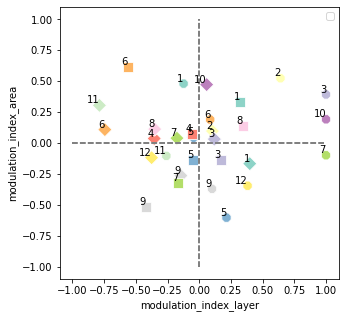

In [53]:
combined_mean_table = combiend_table.groupby(['cluster_id', 'cre_line']).mean().reset_index()
fig, ax = plt.subplots(1,1, figsize = (5,5))
markers = ['D', 's', '8']
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    sns.scatterplot(data=combined_mean_table[combined_mean_table.cre_line==cre], x='modulation_index_layer', y = 'modulation_index_area', hue = 'cluster_id',
         palette = 'Set3', s=100, marker=markers[c], ax=ax)
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]
        plt.text(cluster_table['modulation_index_layer'], cluster_table['modulation_index_area'], str(cluster_id), ha='right', va='bottom')
    ax.legend('')
    plt.plot([0, 0], [-1,1], '--', color='gray')
    plt.plot([-1, 1], [0,0], '--', color='gray')
    
    

Text(0.5, 0, '<- lower --- upper ->')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


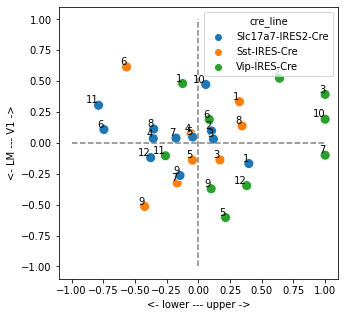

In [55]:
fig, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data=combined_mean_table, x='modulation_index_layer', y = 'modulation_index_area', hue = 'cre_line',
              s=100, ax=ax)
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]    
        plt.text(cluster_table['modulation_index_layer'], cluster_table['modulation_index_area'], str(cluster_id), ha='right', va='bottom')
#     ax.legend('')
plt.plot([0, 0], [-1,1], '--', color='gray')
plt.plot([-1, 1], [0,0], '--', color='gray')
ax.set_ylabel( '<- LM --- V1 ->')
ax.set_xlabel( '<- lower --- upper ->')
   

### Change dot size

In [56]:
combined_mean_table['size_col'] = combined_mean_table['proportion'].copy()

In [57]:
from visual_behavior_glm import GLM_visualization_tools as gvt

In [58]:
color_map = []
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    color_map.append(gvt.project_colors()[cre])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


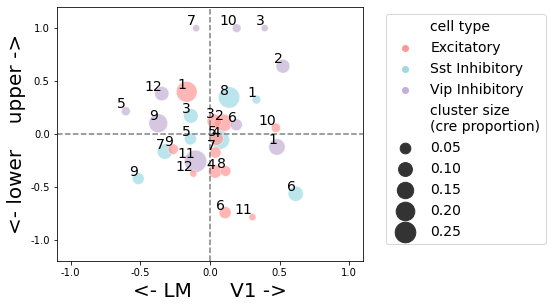

In [59]:
fig, ax = plt.subplots(1,1, figsize = (8,4.5))
plt.rcParams['font.size'] = 14
sns.scatterplot(data=combined_mean_table, y='modulation_index_layer', x = 'modulation_index_area', hue = 'cre_line',
              size='size_col', palette = color_map, sizes=(50, 500), alpha=0.7, ax=ax)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
text = legend.get_texts()
for c, cre in enumerate(combined_mean_table.cre_line.unique()):
    for cluster_id in range(1,13):
        cluster_table = combined_mean_table[(combined_mean_table.cre_line==cre) &
                                           (combined_mean_table.cluster_id==cluster_id)]    
        plt.text(cluster_table['modulation_index_area'], cluster_table['modulation_index_layer'], str(cluster_id), ha='right', va='bottom')
#     ax.legend('')
plt.plot([0, 0], [-1.2,1.4], '--', color='gray')
plt.plot([-1.1, 1.1], [0,0], '--', color='gray')
ax.set_xlabel( '<- LM      V1 ->', fontsize=20)
ax.set_xticks([-1, -.5, 0, .5, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_xticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0']) 
ax.set_ylabel( '<- lower    upper ->', fontsize=20)
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_ylim([-1.2, 1.2])
ax.set_yticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0']) 
text[0].set_text('cell type')
text[1].set_text('Excitatory')
text[2].set_text('Sst Inhibitory')
text[3].set_text('Vip Inhibitory')
text[4].set_text('cluster size \n(cre proportion)')
plt.tight_layout()
   

### Cell metrics
                 

In [17]:
%%time
import visual_behavior.ophys.response_analysis.cell_metrics as cm 

data_type = 'filtered_events'
condition = 'images' #changes or omissions
session_subset = 'full_session' #engaged
inclusion_criteria = 'platform_experiment_table'
    
stimuli = 'all_images'
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
stimuli = 'pref_image'
response_metrics_pref = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|███████▎                                                                         | 36/402 [00:03<00:32, 11.43it/s]

problem for experiment 891994418


 12%|██████████                                                                       | 50/402 [00:04<00:26, 13.04it/s]

problem for experiment 948507789


 23%|██████████████████▌                                                              | 92/402 [00:09<00:27, 11.09it/s]

problem for experiment 994790561


 34%|███████████████████████████▍                                                    | 138/402 [00:14<00:25, 10.16it/s]

problem for experiment 993369859


 36%|████████████████████████████▋                                                   | 144/402 [00:15<00:22, 11.43it/s]

problem for experiment 993891845


 38%|██████████████████████████████▋                                                 | 154/402 [00:16<00:27,  8.86it/s]

problem for experiment 994082680


 46%|████████████████████████████████████▌                                           | 184/402 [00:20<00:23,  9.23it/s]

problem for experiment 851085100


 47%|█████████████████████████████████████▊                                          | 190/402 [00:21<00:22,  9.43it/s]

problem for experiment 851085109


 48%|██████████████████████████████████████▍                                         | 193/402 [00:21<00:25,  8.30it/s]

problem for experiment 851085105


 51%|████████████████████████████████████████▊                                       | 205/402 [00:24<00:30,  6.43it/s]

problem for experiment 991852002


 52%|█████████████████████████████████████████▉                                      | 211/402 [00:24<00:21,  9.08it/s]

problem for experiment 991852001


 55%|████████████████████████████████████████████▏                                   | 222/402 [00:25<00:13, 13.84it/s]

problem for experiment 991852004
problem for experiment 991852005


 65%|███████████████████████████████████████████████████▋                            | 260/402 [00:30<00:17,  8.07it/s]

problem for experiment 977978321


 68%|██████████████████████████████████████████████████████▌                         | 274/402 [00:31<00:10, 12.18it/s]

problem for experiment 981178537


 70%|████████████████████████████████████████████████████████                        | 282/402 [00:32<00:11, 10.84it/s]

problem for experiment 882551935


 72%|█████████████████████████████████████████████████████████▎                      | 288/402 [00:33<00:12,  9.31it/s]

problem for experiment 882551937


 72%|█████████████████████████████████████████████████████████▋                      | 290/402 [00:33<00:10, 10.62it/s]

problem for experiment 882551947


 74%|██████████████████████████████████████████████████████████▉                     | 296/402 [00:33<00:09, 11.54it/s]

problem for experiment 951213203


 80%|████████████████████████████████████████████████████████████████▎               | 323/402 [00:36<00:06, 12.45it/s]

problem for experiment 1050762972


 82%|█████████████████████████████████████████████████████████████████▍              | 329/402 [00:37<00:06, 10.52it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 87%|█████████████████████████████████████████████████████████████████████▎          | 348/402 [00:39<00:05,  9.58it/s]

problem for experiment 1076776838


 91%|████████████████████████████████████████████████████████████████████████▋       | 365/402 [00:41<00:03, 10.91it/s]

problem for experiment 1078904675


 93%|██████████████████████████████████████████████████████████████████████████▍     | 374/402 [00:42<00:02, 11.76it/s]

problem for experiment 1077597082
problem for experiment 1082841182


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:46<00:00,  8.64it/s]
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 376 experiments in the returned cell_metrics table


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


  9%|███████                                                                          | 35/402 [00:06<00:45,  8.13it/s]

problem for experiment 891994418


 12%|██████████                                                                       | 50/402 [00:08<00:38,  9.19it/s]

problem for experiment 948507789


 23%|██████████████████▎                                                              | 91/402 [00:13<00:26, 11.70it/s]

problem for experiment 994790561


 34%|███████████████████████████▍                                                    | 138/402 [00:18<00:22, 11.50it/s]

problem for experiment 993369859


 36%|████████████████████████████▋                                                   | 144/402 [00:19<00:24, 10.35it/s]

problem for experiment 993891845


 38%|██████████████████████████████▏                                                 | 152/402 [00:20<00:26,  9.43it/s]

problem for experiment 993369863
problem for experiment 994082680


 46%|████████████████████████████████████▍                                           | 183/402 [00:23<00:21, 10.08it/s]

problem for experiment 851085100


 48%|██████████████████████████████████████▏                                         | 192/402 [00:24<00:16, 12.99it/s]

problem for experiment 851085109
problem for experiment 851085105


 51%|████████████████████████████████████████▊                                       | 205/402 [00:25<00:16, 11.86it/s]

problem for experiment 991852002


 52%|█████████████████████████████████████████▌                                      | 209/402 [00:26<00:21,  9.10it/s]

problem for experiment 991852001


 55%|███████████████████████████████████████████▊                                    | 220/402 [00:27<00:15, 11.91it/s]

problem for experiment 991852004


 55%|████████████████████████████████████████████▏                                   | 222/402 [00:27<00:14, 12.55it/s]

problem for experiment 991852005


 64%|███████████████████████████████████████████████████▎                            | 258/402 [00:31<00:13, 10.77it/s]

problem for experiment 977978321


 68%|██████████████████████████████████████████████████████▌                         | 274/402 [00:32<00:11, 10.79it/s]

problem for experiment 981178537


 70%|████████████████████████████████████████████████████████                        | 282/402 [00:33<00:10, 11.95it/s]

problem for experiment 882551935


 72%|█████████████████████████████████████████████████████████▎                      | 288/402 [00:34<00:09, 11.53it/s]

problem for experiment 882551937


 72%|█████████████████████████████████████████████████████████▉                      | 291/402 [00:34<00:08, 13.09it/s]

problem for experiment 882551947


 73%|██████████████████████████████████████████████████████████▎                     | 293/402 [00:34<00:09, 11.28it/s]

problem for experiment 951213203


 81%|████████████████████████████████████████████████████████████████▍               | 324/402 [00:37<00:06, 11.74it/s]

problem for experiment 1050762972


 82%|█████████████████████████████████████████████████████████████████▎              | 328/402 [00:38<00:06, 12.22it/s]

problem for experiment 1051249031
problem for experiment 1051423446


 87%|█████████████████████████████████████████████████████████████████████▎          | 348/402 [00:40<00:04, 11.20it/s]

problem for experiment 1076776838


 91%|████████████████████████████████████████████████████████████████████████▋       | 365/402 [00:41<00:03, 12.18it/s]

problem for experiment 1078904675


 93%|██████████████████████████████████████████████████████████████████████████▏     | 373/402 [00:42<00:02, 10.55it/s]

problem for experiment 1077597082
problem for experiment 1082841182


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:46<00:00,  8.73it/s]
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['condition', 'data_type', 'exception', 'filter_events', 'interpolate',
       'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events'],
      dtype='object')]

  encoding=encoding,


there are 375 experiments in the returned cell_metrics table


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Wall time: 1min 58s


In [18]:
print(len(response_metrics.ophys_experiment_id.unique()), len(response_metrics_pref.ophys_experiment_id.unique()))
      ## 402


376 375


In [19]:
response_metrics.keys() #'running_modulation_index', 'fano_factor', 'reliability'

Index(['cell_specimen_id', 'pref_image', 'non_pref_image',
       'image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'mean_response',
       'fraction_significant_p_value_gray_screen', 'fano_factor',
       'reliability', 'running_modulation_index', 'ophys_experiment_id',
       'condition', 'session_subset', 'stimuli', 'data_type', 'interpolate',
       'output_sampling_rate', 'response_window', 'use_events',
       'filter_events', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type',

In [20]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
n_clusters = 14 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')


filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
   

In [21]:
## get pivoted results
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas
import visual_behavior.data_access.utilities as utilities
import visual_behavior.data_access.loading as loading


In [22]:
glm_version = '24_events_all_L2_optimize_by_session'

# run_params, results, results_pivoted, weights_df = gfd.load_analysis_dfs(glm_version)

# get across session normalized dropout scores
df, failed_cells = gas.load_cells(glm_version, clean_df=True)
df = df.set_index('identifier')

Loading list of matched cells


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [03:14<00:00, 20.18it/s]


0 cells could not be loaded


In [23]:
# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')


# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')


11763 len(results_pivoted)
11763 len(results_pivoted)


In [24]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


In [25]:
len(matched_cells)

3921

##### keep results_pivoted for matched cells only

In [26]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [27]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

# limit to features used for clustering
features = processing.get_features_for_clustering()
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

#### keep response metrics for matched cells only

In [28]:

response_metrics_sel = response_metrics[response_metrics.ophys_experiment_id.isin(matched_experiments)]
response_metrics_sel = response_metrics_sel [response_metrics_sel .cell_specimen_id.isin(matched_cells)]

response_metrics_pref_sel = response_metrics_pref[response_metrics_pref.ophys_experiment_id.isin(matched_experiments)]
response_metrics_pref_sel = response_metrics_pref_sel[response_metrics_pref_sel .cell_specimen_id.isin(matched_cells)]


##### get cluster metrics

In [29]:
# for each cre
cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')


3921 cells in cell_metadata for feature_matrix


In [30]:
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.keys()

['Familiar' 'Novel 1' 'Novel >1']
Index(['cluster_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'fraction_cre', 'cre_line', 'F_max',
       'N1_max', 'N2_max', 'abs_max'],
      dtype='object')


Index(['cluster_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'fraction_cre', 'cre_line', 'F_max',
       'N1_max', 'N2_max', 'abs_max', 'n_cells_cluster'],
      dtype='object')

### Plot cell metrics across clusters

In [248]:
# rm_features = ['lifetime_sparseness', 'fano_factor', 'reliability', 'running_modulation_index', 'mean_response',
#               'image_selectivity_index_one_vs_all', 'image_selectivity_index', ]
# rm_features =  ['fano_factor', 'reliability', 'running_modulation_index', 'mean_response',]
# all images
rm_sel_all = response_metrics_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_all = rm_sel_all.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()

# preferred image only
rm_sel_pref = response_metrics_pref_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_pref = rm_sel_pref.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()




#### Plot distributions with statistics

In [228]:
experience_levels = ['Familiar', 'Novel 1', 'Novel >1']


In [224]:
def add_significance(sample1, sample2, test='2ttest'):
    
    
    if len(sample1)!=0 and len(sample2)!=0:
        nan_mask = np.isnan(sample1)
        # Remove NaN values from the array
        sample1_without_nans = sample1[~nan_mask]
    
    
        nan_mask = np.isnan(sample2)
        # Remove NaN values from the array
        sample2_without_nans = sample2[~nan_mask]

        if test == '2ttest':

            # Perform two-sample t-test (parametric)
            t, p = stats.ttest_ind(sample1_without_nans, sample2_without_nans)

        elif test == 'MW':

            # Perform Mann-Whitney U test (non-parametric)
            t, p = stats.mannwhitneyu(sample1_without_nans, sample2_without_nans)

        elif test == 'W':
            from scipy.stats import wilcoxon
            try:            
                diff = np.squeeze(sample1)- np.squeeze(sample2)
                res = wilcoxon(diff)# diff)
                t = res.statistic
                p = res.pvalue
            except:
                t=np.nan
                p=np.nan
        else:
            print('Test was not recognized')
            t=np.nan
            p=np.nan
    else:
        t=np.nan
        p=np.nan
        
    return t,p
    

In [175]:
def plot_distribution(data_array1, data_array2, exp_level_1, exp_level_2, 
                      ax = None, bins=30, density=True, label=False, test='MW', suffix=''):
    ''' function to plot two separate distribution of response metrics 
    test can be MW for two sample comparison or W for within one sample comparison'''
    
    from visual_behavior_glm import GLM_visualization_tools as gvt    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    if exp_level_1 == exp_level_2:
        linecolor_1 = 'blue'
        linecolor_2 = 'black'
    else:
        linecolor_1 = None
        linecolor_2 = None 
        
    
    ax.hist(data_array1, bins=bins, density=density, alpha=0.5, color=gvt.project_colors()[exp_level_1], edgecolor=linecolor_1, label=label)
    ax.hist(data_array2, bins=bins, density=density, alpha=0.5, color=gvt.project_colors()[exp_level_2], edgecolor=linecolor_2, label=label)
    
    # add stats if both data arrays are not empty
    if len(data_array1)!=0 and len(data_array2)!=0:
        t, p = add_significance(data_array1, data_array2, test=test)
        ymax = ax.get_yticks()[-1]
        xmin = ax.get_xticks()[0]
        ax.text(xmin, ymax+ymax*.2, f'{test} p-value: {p:.4f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_title(cre)
    ax.set_xlabel(rm_f+ suffix)
    
    plt.tight_layout()

    

In [176]:
def plot_boxplot(data_array1, data_array2, exp_level_1, exp_level_2, 
                      ax = None, patch_artist=True, widths = 0.5, test='MW', suffix=''):
    ''' function to plot two separate distribution of response metrics 
    test can be MW for two sample comparison or W for within one sample comparison'''
    
    from visual_behavior_glm import GLM_visualization_tools as gvt    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    if exp_level_1 == exp_level_2:
        linecolor_1 = 'blue'
        linecolor_2 = 'black'
    else:
        linecolor_1 = None
        linecolor_2 = None 
    
    stats=True
    if len(data_array1)==0:
        data_array1 = [np.nan, np.nan]
        stats = False
    else:
        nan_mask = np.isnan(data_array1)
        # Remove NaN values from the array
        data_array1 = data_array1[~nan_mask]
    

    if len(data_array2)==0:
        data_array2 = [np.nan, np.nan]
        stats = False
    else:
        nan_mask = np.isnan(data_array2)
        # Remove NaN values from the array
        data_array2 = data_array2[~nan_mask]
        
        
    
    print(np.shape([data_array1, data_array2]))
    bplot = ax.boxplot(np.squeeze([data_array1,data_array2]).T, patch_artist=patch_artist, widths=widths)
    colors = [gvt.project_colors()[exp_level_1],gvt.project_colors()[exp_level_2]]
    # change color
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_yscale('log')  
    # add stats if both data arrays are not empty
    if stats is True:
        t, p = add_significance(data_array1, data_array2, test=test)
        ymax = ax.get_yticks()[-1]
        xmin = ax.get_xticks()[0]
        ax.text(xmin, ymax+ymax*.2, f'{test} p-value: {p:.4f}', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
    if exp_level_2 == 'Novel >1':
        exp_level_2 = 'Novel+'
    if exp_level_1 == 'Novel >1':
        xp_level_1 = 'Novel+'
    ax.set_xticklabels([exp_level_1, exp_level_2])
    ax.set_title(cre)
    ax.set_xlabel(rm_f+ suffix)
    
    plt.tight_layout()

In [232]:
# rm_features = ['lifetime_sparseness', 'fano_factor', 'reliability', 'running_modulation_index', 'mean_response',
#               'image_selectivity_index_one_vs_all', 'image_selectivity_index', ]
rm_features = ['lifetime_sparseness', 'fano_factor', 'reliability', 'running_modulation_index', 
                'image_selectivity_index_one_vs_all', 'image_selectivity_index']
        

In [250]:

df = rm_unstacked_all
suffix='_all'
folder = 'distributions_all_images'

for index, rm_f in enumerate(rm_features):
    for cluster_id_1 in range(1,13): #5
        for cluster_id_2 in range(1,13): #9
            for exp_level_1 in experience_levels:
                for exp_level_2 in experience_levels:
                        
                    fig,ax = plt.subplots(1,3, figsize=(15,7), )#sharex=True)
                    ax=ax.ravel()
                    for c,cre in enumerate(cre_lines):
                        
                        # get data from first cluster
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_1-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try:
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_1)]]
                            data_array1=data.values

                        except:
                            data_array1 =[]
                            print('no cells')
                            
                        # get data from second cluster    
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_2-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try: 
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_2)]]
                            data_array2=data.values
                        except:
                            data_array2 = []
                            print('no cells')
                            
                        # change to one sample test if comparing cells within the same cluster
                        if cluster_id_1 == cluster_id_2:
                            test='W'
                        else:
                            test='MW'
                                     
                        # plot figure
                        if rm_f == 'mean_response':
                            
                            plot_boxplot(data_array1, data_array2, exp_level_1, exp_level_2, 
                                         ax = ax[c], patch_artist=True, widths = 0.5, test=test, suffix=suffix)
                        else:
                            plot_distribution(data_array1, data_array2, exp_level_1, exp_level_2, 
                                          ax = ax[c], bins=30, density=True, label=False, test=test, suffix=suffix)
                    if exp_level_2 == 'Novel >1':
                        exp_level_2 = 'Novel+'
                    if exp_level_1 == 'Novel >1':
                        exp_level_1 = 'Novel+'
                    plt.suptitle(f'cluster {cluster_id_1} and cluster {cluster_id_2}')
                    plt.tight_layout()
                    # figname
                    filename = f'{rm_f}_{cluster_id_1}_{cluster_id_2}_{exp_level_1}_{exp_level_2}.png'
                    figname = os.path.join(save_dir,folder , filename) 
                    fig.savefig(figname)
                    plt.close('all')


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


no cells


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
n

In [ ]:
### for mean_responses plot boxplot

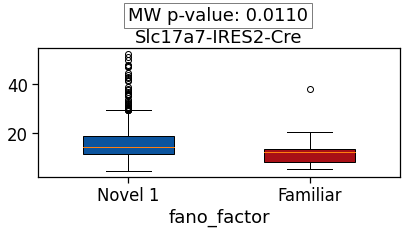

In [95]:
fig, ax = plt.subplots(1,1)
x =data_array1[~np.isnan(data_array1)]
y =data_array2[~np.isnan(data_array2)]
plot_boxplot(x, y, exp_level_1, exp_level_2,ax=ax)

{'whiskers': [<matplotlib.lines.Line2D at 0x1fe190438c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe19043088>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe19009dc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe19043d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe19043308>],
 'means': []}

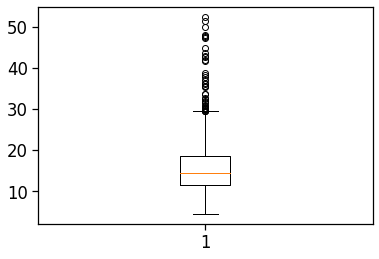

In [76]:
plt.boxplot(x)

In [75]:
x =data_array1[~np.isnan(data_array1)]
y =data_array2[~np.isnan(data_array2)]

### Plot response properties vs experience and feature selectivity

In [179]:
coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)


c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1442: RuntimeWarning: invalid value encountered in double_scalars
  exp_mod_persistence = (row[novel_plus]-row[novel])/(row[novel_plus]+row[novel])
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1420: RuntimeWarning: invalid value encountered in double_scalars
  feature_selectivity = (values[0] - (np.mean(values[1:]))) / (values[0] + (np.mean(values[1:])))
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:1424: RuntimeWarning: invalid value encountered in double_scalars
  experience_selectivity = (values[0] - (np.mean(values[1:]))) / (values[0] + (np.mean(values[1:])))
c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\process

In [203]:
measure = ['lifetime_sparseness']
tmp = rm_unstacked[measure].droplevel(0, axis=1)
tmp2 = coding_score_metrics.join(tmp)

<AxesSubplot:xlabel='dominant_experience_level', ylabel='Novel >1'>

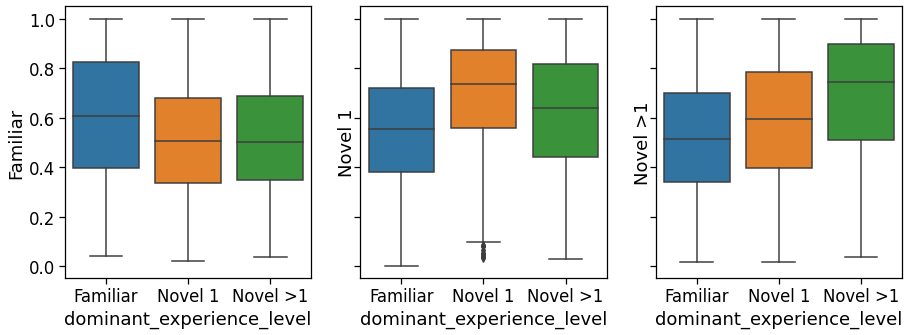

In [215]:
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey=True)
sns.boxplot(data=tmp2, x = 'dominant_experience_level', y='Familiar', order = ['Familiar', 'Novel 1', 'Novel >1'],ax=ax[0])
sns.boxplot(data=tmp2, x = 'dominant_experience_level', y='Novel 1', order = ['Familiar', 'Novel 1', 'Novel >1'],ax=ax[1])
sns.boxplot(data=tmp2, x = 'dominant_experience_level', y='Novel >1', order = ['Familiar', 'Novel 1', 'Novel >1'],ax=ax[2])

In [217]:
tmp2.keys()

Index(['dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'experience_modulation', 'exp_mod_direction',
       'exp_mod_persistence', 'feature_sel_within_session',
       'feature_sel_across_sessions', 'ophys_experiment_id', 'cre_line',
       'cluster_id', 'labels', 'within_cluster_correlation', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'date', 'f

<AxesSubplot:xlabel='experience_selectivity', ylabel='experience_modulation'>

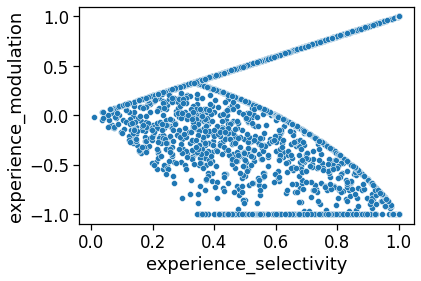

In [219]:
sns.scatterplot(data = tmp2, x = 'experience_selectivity', y = 'experience_modulation')

<AxesSubplot:xlabel='experience_selectivity', ylabel='feature_selectivity'>

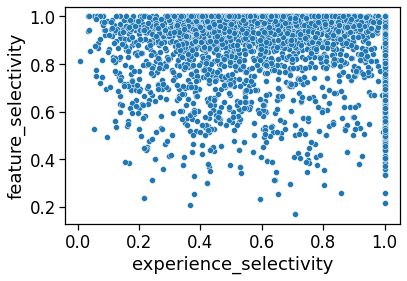

In [220]:
sns.scatterplot(data = tmp2, x = 'experience_selectivity', y = 'feature_selectivity')

In [222]:
tmp2['selectivity_change'] = tmp2['Novel 1']-tmp2['Familiar']

<AxesSubplot:xlabel='exp_mod_direction', ylabel='selectivity_change'>

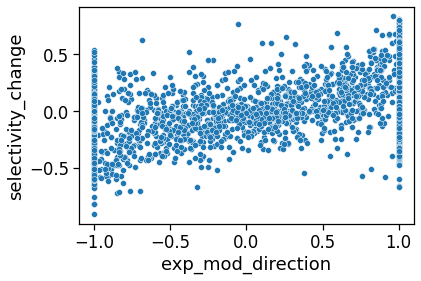

In [229]:
sns.scatterplot(data = tmp2, x = 'exp_mod_direction', y = 'selectivity_change')

<AxesSubplot:xlabel='selectivity_change', ylabel='exp_mod_direction'>

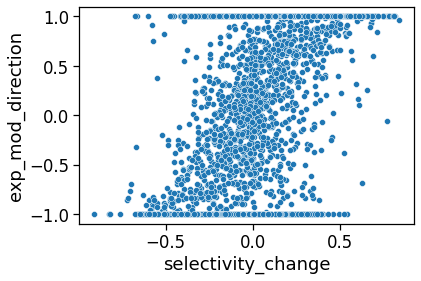

In [230]:
sns.scatterplot(data = tmp2, x = 'selectivity_change', y = 'exp_mod_direction')

In [225]:
tmp2['sel_change_novel'] = tmp2['Novel 1']-tmp2['Novel >1']

<AxesSubplot:xlabel='sel_change_novel', ylabel='exp_mod_direction'>

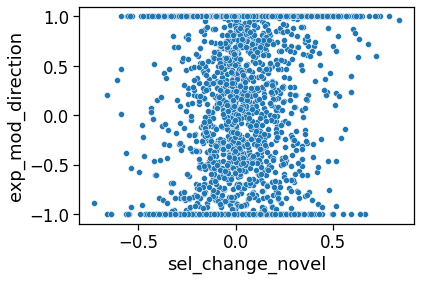

In [231]:
sns.scatterplot(data = tmp2, x = 'sel_change_novel', y = 'exp_mod_direction')

AttributeError: 'bool' object has no attribute 'all'

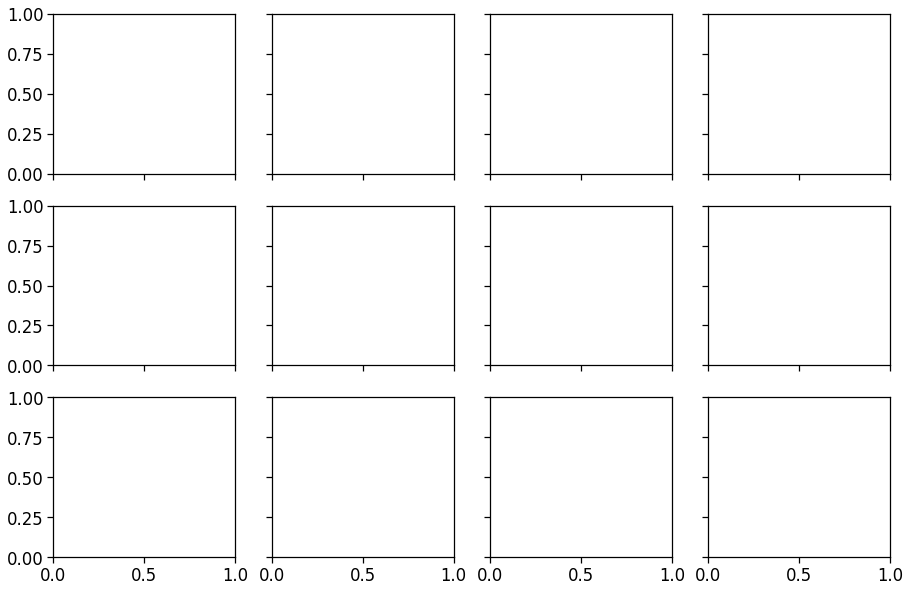

In [228]:
fig,ax = plt.subplots(3,4, figsize=(15,10), sharex =True, sharey='row')
ax=ax.ravel()
index=6
for c, cre in enumerate(cre_lines):
    for cluster_id in range(0,12):
        tmp = cluster_df[(cluster_df.cluster_id==cluster_id) &
                        (cluster_df.cre_line==cre)]
        cids = tmp.cell_specimen_id.values
        sns.pointplot(data=tmp2.loc[cids], y='selectivity_change', x = c, color=gvt.project_colors()[cre], ax=ax[cluster_id])
        ax[cluster_id].set_title(f'cluster id = {cluster_id+1}')
plt.suptitle(rm_features[index])
plt.tight_layout()
filename = f'{rm_features[index]}_by_cluster.png'
fig.savefig(os.path.join(save_dir, filename))